In [1]:
import pandas as pd
from yaml import load, dump, safe_load, safe_load_all, unsafe_load_all, safe_load
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper
import os
from collections import defaultdict
import jmespath
from pathlib import Path
import minizinc
from ruamel.yaml import YAML
from multiprocessing import cpu_count
from itertools import cycle
from collections import Counter

In [2]:
from pathlib import Path

# Loading data without cache
attempt_bb_without_cache_folder = Path.cwd() / Path('./attempt_bb_without_cache')
# load CSVs but skip hidden/system files
df_without_cache = pd.concat([
    pd.read_csv(f)
    for f in attempt_bb_without_cache_folder.glob('*.csv')
    if f.is_file() and not f.name.startswith('.')  # ignore files like .DS_Store, etc.
])
df_without_cache['hits'] = df_without_cache['hits'].astype(int)
df_without_cache['time'] = pd.to_timedelta(df_without_cache['time'], unit='nanoseconds')
df_without_cache = df_without_cache[['nurses_no', 'hits', 'time']]
df_without_cache

,nurses_no,hits,time
0,2,0,0 days 00:00:02.154016417
1,2,0,0 days 00:00:02.451832875
2,2,0,0 days 00:00:00.823697208
3,2,0,0 days 00:00:00.844782959
4,2,0,0 days 00:00:00.793170958
...,...,...,...
491,8,0,0 days 00:00:00.770598125
492,8,0,0 days 00:00:00.766788042
493,8,0,0 days 00:00:00.766498584
494,8,0,0 days 00:00:00.773732417


In [3]:
from pathlib import Path
import json, io

# Loading data with cache
attempt_bb_with_cache_folder = Path.cwd() / Path('./attempt_bb_with_cache')
# load CSVs but skip hidden/system files
df_with_cache = pd.concat([
    pd.read_csv(f)
    for f in attempt_bb_with_cache_folder.glob('*.csv')
    if f.is_file() and not f.name.startswith('.')  # ignore files like .DS_Store, etc.
])
df_with_cache['hits'] = df_with_cache['hits'].astype(int)
df_with_cache['time'] = pd.to_timedelta(df_with_cache['time'], unit='nanoseconds')
df_with_cache = df_with_cache[['nurses_no', 'hits', 'time']]
df_with_cache

,nurses_no,hits,time
0,5,0,0 days 00:00:01.276891500
1,5,0,0 days 00:00:00.822233833
2,5,0,0 days 00:00:00.805006709
3,5,0,0 days 00:00:00.835481
4,5,1,0 days 00:00:00.000004333
...,...,...,...
6190,23,1,0 days 00:00:00.000003125
6191,23,1,0 days 00:00:00.000002791
6192,23,1,0 days 00:00:00.000001833
6193,23,1,0 days 00:00:00.000001167


In [4]:
# load all .txt files in the folder, skip lines that parse as JSON
import re
df_with_cache_obj = {
    'obj': [],
    'time': [],
}
with (attempt_bb_with_cache_folder / "attempt_bb_with_cache.txt").open('r') as f:
    for ln in f:
        try:
            var = json.loads(ln.strip('\n'))
            if (var.get('type') == 'solution') \
                and (match := re.search(r'obj = (\d+);', var['output']['dzn'])):
                    df_with_cache_obj['obj'].append(match.group(1))
                    df_with_cache_obj['time'].append(var['time'])
        except json.JSONDecodeError:
            pass
df_with_cache_obj = pd.DataFrame(df_with_cache_obj)
df_with_cache_obj['time'] = pd.to_timedelta(df_with_cache_obj['time'], unit='milliseconds')
df_with_cache_obj

,obj,time
0,661,0 days 00:01:53.191000
1,650,0 days 00:03:29.591000
2,649,0 days 00:04:56.862000
3,645,0 days 00:20:51.347000
4,643,0 days 00:43:56.144000
5,640,0 days 01:04:21.002000
6,634,0 days 01:07:11.770000
7,600,0 days 01:15:14.248000
8,599,0 days 01:34:29.141000


In [5]:
import re
df_without_cache_obj = {
    'obj': [],
    'time': [],
}
with (attempt_bb_without_cache_folder / "attempt_bb_without_cache.txt").open('r') as f:
    for ln in f:
        try:
            var = json.loads(ln.strip('\n'))
            if (var.get('type') == 'solution') \
                and (match := re.search(r'obj = (\d+);', var['output']['dzn'])):
                    df_without_cache_obj['obj'].append(match.group(1))
                    df_without_cache_obj['time'].append(var['time'])
        except json.JSONDecodeError:
            pass
df_without_cache_obj = pd.DataFrame(df_without_cache_obj)
df_without_cache_obj['time'] = pd.to_timedelta(df_without_cache_obj['time'], unit='milliseconds')
df_without_cache_obj

,obj,time
0,661,0 days 00:09:08.644000
1,650,0 days 00:24:56.098000
2,649,0 days 01:12:19.763000


In [6]:
df_decomp = pd.read_csv('/Users/kieronqtran/Projects/Deeker1/blackbox/NRPwF/df_comp.csv')
df_decomp['time'] = pd.to_timedelta(df_decomp['time'], unit='seconds')
df_decomp['obj'] = df_decomp['recompute_obj']
df_decomp

,configuration,data_file,recompute_obj,time,obj
0,Gecode_Decomp,dzn/n_bio_instance_17.dzn,661,0 days 00:00:02.389000,661
1,Gecode_Decomp,dzn/n_bio_instance_17.dzn,643,0 days 00:00:02.557000,643
2,Gecode_Decomp,dzn/n_bio_instance_17.dzn,609,0 days 00:00:10.848000,609
3,Gecode_Decomp,dzn/n_bio_instance_17.dzn,609,0 days 00:00:13.748000,609
4,Gecode_Decomp,dzn/n_bio_instance_17.dzn,596,0 days 00:31:42.480000,596
5,Gecode_Decomp,dzn/n_bio_instance_17.dzn,596,0 days 00:31:43.976000,596


In [13]:
# set matplotlib to a light theme
plt.style.use('default')

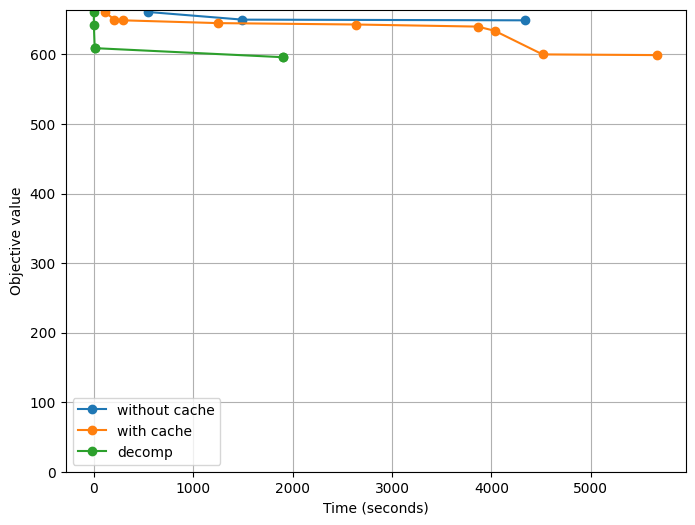

In [17]:
import matplotlib.pyplot as plt

# ensure obj is numeric
df_without_cache_obj['obj'] = df_without_cache_obj['obj'].astype(int)
df_with_cache_obj['obj'] = df_with_cache_obj['obj'].astype(int)
df_decomp['obj'] = df_decomp['obj'].astype(int)

plt.figure(figsize=(8, 6))
plt.plot(df_without_cache_obj['time'].dt.total_seconds(), df_without_cache_obj['obj'], 'o-', label='without cache')
plt.plot(df_with_cache_obj['time'].dt.total_seconds(), df_with_cache_obj['obj'], 'o-', label='with cache')
plt.plot(df_decomp['time'].dt.total_seconds(), df_decomp['obj'], 'o-', label='decomp')

plt.xlabel('Time (seconds)')  
plt.ylabel('Objective value')
# plt.title('Comparison between nurse rostering with fatigue with cache vs without cache vs decomp')
plt.ylim(ymin=0)
plt.legend()
plt.grid(True)
plt.show()
# plt.savefig('plot.eps')
# plt.close()

In [7]:
# Compute and display overall hit percentage in df_with_cache
hit_ratio = df_with_cache['hits'].sum() / len(df_with_cache)
print(f"Overall hit percentage: {hit_ratio:.2%}")

Overall hit percentage: 94.70%


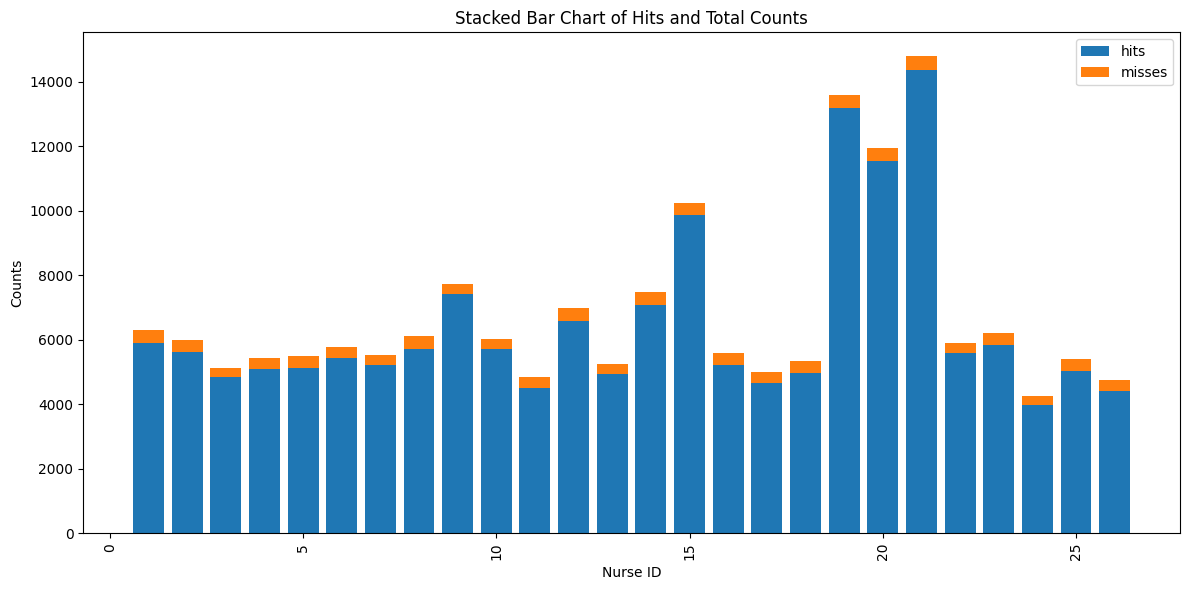

In [16]:
df_with_cache['hits'] = df_with_cache['hits'].astype(int)
agg = df_with_cache.groupby(['nurses_no']).sum()['hits']
total = df_with_cache.value_counts('nurses_no')

import matplotlib.pyplot as plt

# Align series in a DataFrame
df_chart = pd.DataFrame({'agg': agg, 'total': total})
df_chart['remaining'] = df_chart['total'] - df_chart['agg']
df_chart = df_chart.reset_index()
df_chart['nurses_no'] = df_chart['nurses_no'].astype(int)
df_chart = df_chart.sort_values(['nurses_no'])

plt.figure(figsize=(12, 6))
plt.bar(df_chart['nurses_no'], df_chart['agg'], label='hits')
plt.bar(df_chart['nurses_no'], df_chart['remaining'], bottom=df_chart['agg'], label='misses')
plt.xticks(rotation=90)
plt.xlabel('Nurse ID')
plt.ylabel('Counts')
plt.title('Stacked Bar Chart of Hits and Total Counts')
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig('hits_vs_misses_cache_in_the_process.eps')
# plt.close()

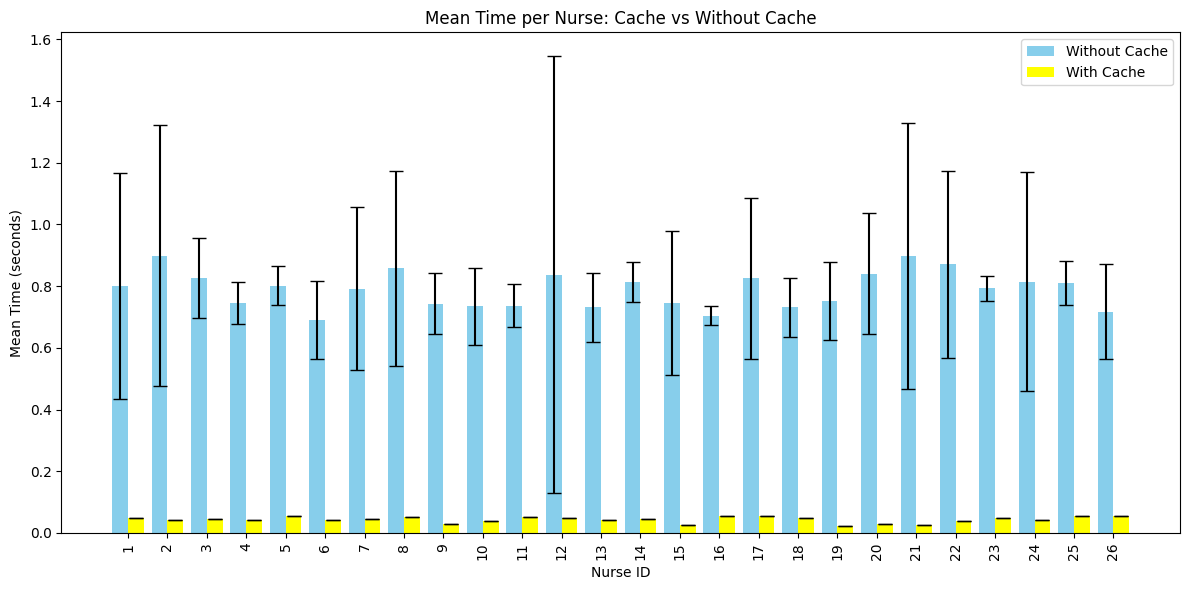

In [19]:
# Compute mean and std time per nurse for both scenarios
stats_no_cache = df_without_cache.groupby('nurses_no')['time'].agg(['mean', 'std'])
stats_with_cache = df_with_cache.groupby('nurses_no')['time'].agg(['mean', 'std'])

# Convert timedeltas to seconds
stats_no_cache['mean'] = stats_no_cache['mean'].dt.total_seconds()
stats_no_cache['std']  = stats_no_cache['std'].dt.total_seconds()
stats_with_cache['mean'] = stats_with_cache['mean'].dt.total_seconds()
stats_with_cache['std']  = df_with_cache[df_with_cache['hits'] == 1].groupby('nurses_no')['time'].std().dt.total_seconds()

# Split into separate Series
time_no_cache_mean = stats_no_cache['mean']
time_no_cache_std  = stats_no_cache['std']
time_with_cache_mean = stats_with_cache['mean']
time_with_cache_std  = stats_with_cache['std']

# Combine into one DataFrame
df_time = pd.DataFrame({
    'nurses_no': time_no_cache_mean.index,
    'without_cache_mean': time_no_cache_mean.values,
    'without_cache_std': time_no_cache_std.values,
    'with_cache_mean': time_with_cache_mean.reindex(time_no_cache_mean.index).values,
    'with_cache_std': time_with_cache_std.reindex(time_no_cache_mean.index).values
})

# Plot side-by-side bar chart with error bars
plt.figure(figsize=(12, 6))
x = df_time['nurses_no']
width = 0.4

plt.bar(x - width/2,
    df_time['without_cache_mean'],
    width=width,
    yerr=df_time['without_cache_std'],
    capsize=5,
    label='Without Cache',
    color='skyblue')

plt.bar(x + width/2,
        df_time['with_cache_mean'],
        width=width,
        yerr=df_time['with_cache_std'],
        capsize=5,
        label='With Cache',
        color='yellow')

plt.xlabel('Nurse ID')
plt.ylabel('Mean Time (seconds)')
plt.title('Mean Time per Nurse: Cache vs Without Cache')
plt.xticks(x, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig('mean_compute_time_per_nurse.eps')
# plt.close()

In [10]:
df_with_cache['time'].sum(), df_without_cache['time'].sum()

(Timedelta('0 days 01:58:22.276559913'),
 Timedelta('0 days 01:41:59.773705008'))

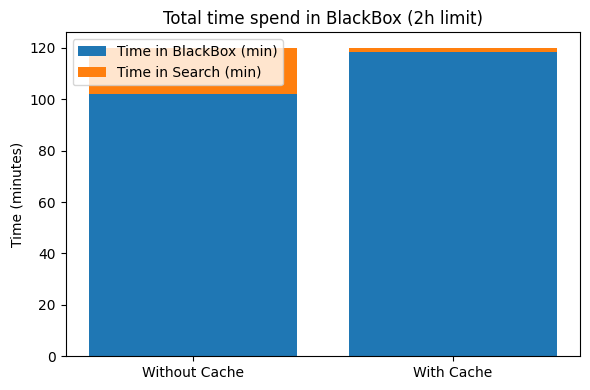

In [18]:
df_with_cache_total_time = df_with_cache['time'].sum()
df_without_cache_total_time = df_without_cache['time'].sum()
df_without_cache_remain_time = pd.Timedelta(hours=2) - df_without_cache_total_time
df_with_cache_remain_time = pd.Timedelta(hours=2) - df_with_cache_total_time
labels = ['Without Cache', 'With Cache']
used = [
    df_without_cache_total_time.total_seconds() / 60,
    df_with_cache_total_time.total_seconds() / 60
]
remaining = [
    df_without_cache_remain_time.total_seconds() / 60,
    df_with_cache_remain_time.total_seconds() / 60
]
x = range(len(labels))

plt.figure(figsize=(6, 4))
plt.bar(x, used, label='Time in BlackBox (min)')
plt.bar(x, remaining, bottom=used, label='Time in Search (min)')
plt.xticks(x, labels)
plt.ylabel('Time (minutes)')
plt.title('Total time spend in BlackBox (2h limit)')
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig('total_time_spend_in_bb.eps')
# plt.close()

In [ ]:
df_with_cache.groupby('nurses_no')['time'].sum()

nurses_no
1    0 days 00:05:03.178444020
2    0 days 00:04:18.938253592
3    0 days 00:03:45.138307067
4    0 days 00:03:51.300876996
5    0 days 00:04:56.839265474
6    0 days 00:04:07.535896881
7    0 days 00:04:13.448805895
8    0 days 00:05:11.919101807
9    0 days 00:03:38.148273187
10   0 days 00:03:53.832847132
11   0 days 00:04:05.489882784
12   0 days 00:05:38.094454448
13   0 days 00:03:33.287267522
14   0 days 00:05:38.852870441
15   0 days 00:04:35.700585616
16   0 days 00:05:03.531787457
17   0 days 00:04:31.223759382
18   0 days 00:04:15.267309041
19   0 days 00:05:19.374190513
20   0 days 00:05:40.386822068
21   0 days 00:06:00.464799167
22   0 days 00:03:52.517120040
23   0 days 00:04:55.515647687
24   0 days 00:02:58.991653562
25   0 days 00:04:51.698746432
26   0 days 00:04:21.599591702
Name: time, dtype: timedelta64[ns]